<a href="https://colab.research.google.com/github/dtabuena/Images/blob/main/Cell_Pose_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install python-bioformats


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 40.3 MB 2.5 MB/s 
     |████████████████████████████████| 829 kB 32.5 MB/s 
     |████████████████████████████████| 132 kB 44.3 MB/s 
     |████████████████████████████████| 1.3 MB 38.0 MB/s 
     |████████████████████████████████| 79 kB 5.7 MB/s 
     |████████████████████████████████| 9.3 MB 41.2 MB/s 
     |████████████████████████████████| 140 kB 60.0 MB/s 
  Created wheel for python-javabridge: filename=python_javabridge-4.0.3-cp37-cp37m-linux_x86_64.whl size=1628181 sha256=2e7661abf0ea98547775de100d73faacc59df73d133a2629430f230decf7ec71
  Stored in directory: /root/.cache/pip/wheels/63/7e/91/01b1bd8d29b4323834feb5cfec49b857fb212e6efc74ce103c
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=4069c8f6f16dc96cfbc9429a99ea6bf7edd5567038e5501ca4848ea9040ebf76
  Stored in directory: /root/.cache/pip/wheels/56/b0/

In [2]:
import numpy as np
import pandas as pd
import javabridge
import bioformats
import skimage
from skimage import filters
from matplotlib import pyplot as plt
import matplotlib
import os
import scipy
from scipy import ndimage as ndi
javabridge.start_vm(class_path=bioformats.JARS)



def get_drobox_folder(link, new_filename):
    'Download a folder from dropbox and unzip'
    zipped_file_path = "/content/"+new_filename + ".zip"
    unzipped_file_path = "/content/"+new_filename
    if not( os.path.exists(zipped_file_path)):
        !wget -O $zipped_file_path $link    # download with new name
    !echo A | unzip $zipped_file_path -d $unzipped_file_path 
    return new_filename

def get_sub_files(rootdir):
    'Recursively search subfolders and return a list of all files'
    file_list =[]
    for rootdir, dirs, files in os.walk(rootdir): 
            file_list.extend([os.path.join(rootdir,f) for f in files])
    return file_list

folder = get_drobox_folder('https://www.dropbox.com/sh/rv7944fsk9p1mvk/AAC0E8ZTPkr-pfgK8zdC730Sa?dl=0', 'images')
file_list = get_sub_files(folder)
file_list.sort()

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


--2022-10-19 21:39:16--  https://www.dropbox.com/sh/rv7944fsk9p1mvk/AAC0E8ZTPkr-pfgK8zdC730Sa?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/rv7944fsk9p1mvk/AAC0E8ZTPkr-pfgK8zdC730Sa [following]
--2022-10-19 21:39:17--  https://www.dropbox.com/sh/raw/rv7944fsk9p1mvk/AAC0E8ZTPkr-pfgK8zdC730Sa
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc203d9b625c3f36e95ce0fa4fb3.dl.dropboxusercontent.com/zip_download_get/BSjKMlnceZ1CbqVBzytaameIP02xclykXJF-UbM85uGpuoD2lwBhk1XJBoluQgwqjCbq4iSr-75uQf-FG4Okpd8XzHgEAGLYWe2QM_3KOf9d2w# [following]
--2022-10-19 21:39:18--  https://uc203d9b625c3f36e95ce0fa4fb3.dl.dropboxusercontent.com/zip_download_get/BSjKMlnceZ1CbqVBzytaameIP02xclykXJF-UbM85uGpuoD2lwBhk1XJBoluQgwqjCbq4iSr-75uQf-FG4Okpd8XzHg

In [3]:
im_num = 2
print(file_list[im_num])
my_reader = bioformats.get_image_reader('my_image', file_list[im_num])

c_dim = my_reader.rdr.getSizeC()
z_dim = my_reader.rdr.getSizeZ()
x_dim = my_reader.rdr.getSizeX()
y_dim = my_reader.rdr.getSizeY()
print(x_dim,y_dim,c_dim,z_dim)

image = np.empty([x_dim,y_dim,c_dim,z_dim])
for zi in range(z_dim):
    img_zi = my_reader.read(c=None, z=zi,rescale=True)
    image[:,:,:,zi] = img_zi


# image = np.expand_dims(image_zproj, axis=-1)
print(image.shape)
for ci in range(image.shape[2]):
    cim = image[:,:,ci,:]
    flat = cim.flatten()
    max= np.percentile(flat,100)
    assert max>0 , print(flat)
    cim = cim/max
    image[:,:,ci,:] = cim

images/MDGA2_08-25-22_DG_40X_2XZoom_1.oir
800 800 3 17
(800, 800, 3, 17)


In [21]:
def read_image(image_name):
    my_reader = bioformats.get_image_reader('my_image', image_name)

    c_dim = my_reader.rdr.getSizeC()
    z_dim = my_reader.rdr.getSizeZ()
    x_dim = my_reader.rdr.getSizeX()
    y_dim = my_reader.rdr.getSizeY()
    print(x_dim,y_dim,c_dim,z_dim)

    image = np.empty([x_dim,y_dim,c_dim,z_dim])
    for zi in range(z_dim):
        img_zi = my_reader.read(c=None, z=zi,rescale=True)
        image[:,:,:,zi] = img_zi

    for ci in range(image.shape[2]):
        cim = image[:,:,ci,:]
        flat = cim.flatten()
        max= np.percentile(flat,100)
        assert max>0 , print(flat)
        cim = cim/max
        image[:,:,ci,:] = cim
    return image


In [4]:
import os
os.environ["CELLPOSE_LOCAL_MODELS_PATH"] = "/PATH_FOR_MODELS/"

!pip install cellpose
from cellpose import models


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 169 kB 5.5 MB/s 
     |████████████████████████████████| 4.2 MB 51.5 MB/s 
     |████████████████████████████████| 31.0 MB 1.7 MB/s 


In [5]:
# image=image[:,:,:,1:]

In [60]:
# def score_image(image,chan_dim,cell_chan):
chan_dim = 2
cell_chan = 2
z_dim = 3
diameter = 30
min_vox = 500
ch_names = ['target','mCherry','NeuN']




def norm_channels(image,chan_dim,z_dim,):
    '''Transpose ndims, preserve labels'''
    dim_order = np.arange(image.ndim).tolist()
    dim_order = [chan_dim, z_dim] + [d for d in dim_order if d not in [chan_dim, z_dim]]
    chan_dim = [i for i in range(len(dim_order)) if dim_order[i]==chan_dim][0]
    z_dim = [i for i in range(len(dim_order)) if dim_order[i]==z_dim][0]

    '''Normalize channel intensities'''
    image_r=np.transpose(image,dim_order)
    ch_val_list = []
    for ch in range(image_r.shape[chan_dim]):    
        ch_val = image_r[ch,:,:,:]
        for zi in range(image_r.shape[z_dim]):
            ch_val_z = ch_val[zi,:,:]
            ch_val_z = (ch_val_z-np.mean(ch_val_z.flatten())) / np.std(ch_val_z.flatten()) # zscore
            ch_val_z = (ch_val_z) / np.std(ch_val_z.flatten())
            ch_val[zi,:,:] = ch_val_z
        # ch_z = (ch_val-np.mean(ch_val.flatten())) / np.std(ch_val.flatten())
        ch_val_list.append(ch_val)
    image_znorm = np.stack(ch_val_list,axis=0)
    return image_znorm, image_r,chan_dim,z_dim

def mask_image_cellpose(image_r,cell_chan,diameter,exp_dist):
    '''Generate Masks with Cellpose'''
    model = models.Cellpose(model_type='cyto')
    masks, _, _, _ = model.eval(image_r[cell_chan,:,:,:], diameter=diameter, channels=[0,0], stitch_threshold=.001,do_3D=False)
    masks=masks.astype(float)
    exp_masks = masks.copy()
    for zi in range(masks.shape[0]):
        exp_masks[zi,:,:] = skimage.segmentation.expand_labels(exp_masks[zi,:,:], distance=exp_dist)
    return masks, exp_masks


def quant_cells(image_znorm, image_r, exp_masks,chan_dim):
    '''Quantify Cell Intensities'''
    cell_ids =np.arange(0,np.nanmax(exp_masks.flatten()))+1
    cell_df = pd.DataFrame({'cell_id':cell_ids}).set_index('cell_id')
    for ch in range(image_znorm.shape[chan_dim]):
        for cell in cell_df.index:
            cell_df.at[cell,'size'] = np.nansum((exp_masks.flatten()==cell))
            cell_df.at[cell,'mean_'+ch_names[ch]] = np.nansum( image_znorm[ch,:,:,:][exp_masks==cell]) / cell_df.loc[cell,'size']
            cell_df.at[cell,'raw_mean_'+ch_names[ch]] = np.nansum( image_r[ch,:,:,:][exp_masks==cell]) / cell_df.loc[cell,'size']
    return cell_df


def calc_odd(cell_df,t):
    '''Calculate Odds Ratios'''
    is_green = cell_df['mean_target']>t
    not_green = cell_df['mean_target']<=t
    is_red = cell_df['mean_mCherry']>t
    not_red = cell_df['mean_mCherry']<=t

    p_G_nR = np.mean(  is_green[not_red]  )
    p_G_iR = np.mean(  is_green[is_red]  )
    # print('P(G|~R)',p_G_nR)
    # print('P(G|R)',p_G_iR)

    p_R_iG = np.mean(  is_red[is_green]  )
    p_R_nG = np.mean(  is_red[not_green]  )
    # print('P(R|G)',p_R_iG)
    # print('P(R|~G)',p_R_nG)

    num_RnG = np.sum(is_red[not_green] )
    num_nRnG = np.sum(not_red[not_green] )
    num_RG = np.sum(is_red[is_green] )
    num_nRG = np.sum(not_red[is_green] )
    OR = (num_RG * num_nRnG)/ (num_RnG * num_nRG)
    # print('odds',OR)

    results = {'OR':OR,
               'num_RnG':num_RnG,
               'num_nRnG':num_nRnG,
               'num_RG':num_RG,
               'num_nRG':num_nRG,}

    return results


def image_pipeline(image,chan_dim,cell_chan,z_dim,t=1):
    image_znorm, image_r,chan_dim,z_dim = norm_channels(image,chan_dim,z_dim,)
    diameter = 30
    exp_dist = 5
    masks, exp_masks = mask_image_cellpose(image_r,cell_chan,diameter,exp_dist)
    cell_df = quant_cells(image_znorm, image_r, exp_masks,chan_dim)
    results = calc_odd(cell_df,t)

    fov_dict = {'raw_image':image,
            'image_r':image_r,
            'image_znorm':image_znorm,
            'masks':masks,
            'exp_masks':exp_masks,
            'cell_df':cell_df,
            'results':results,
            }
    return fov_dict


In [61]:
from tqdm import tqdm


chan_dim = 2
cell_chan = 2
z_dim = 3
diameter = 30
exp_dist = 5


file_index = [i for i in range(len(file_list)) if 'MDGA' in file_list[i]]
sub_file_list = [file_list[i] for i in file_index]

multi_image_results = []
for f in tqdm( sub_file_list):
    image = read_image(f)
    fov_dict=image_pipeline(image,chan_dim,cell_chan,z_dim)
    fov_dict['image_name']=f
    multi_image_results.append(fov_dict)

  0%|          | 0/3 [00:00<?, ?it/s]

800 800 3 13


 33%|███▎      | 1/3 [05:16<10:33, 316.67s/it]

800 800 3 16


 67%|██████▋   | 2/3 [12:37<06:29, 389.50s/it]

800 800 3 17


100%|██████████| 3/3 [19:16<00:00, 385.62s/it]


In [56]:
for r in multi_image_results:
    print(r['image_name'])
    print(r['results'])

images/MDGA2_08-22-22_S001_DG_40X_2XZoom_1.oir
{'OR': nan, 'num_RnG': 7, 'num_nRnG': 0, 'num_RG': 224, 'num_nRG': 0}
images/MDGA2_08-24-22_DG_40X_2XZoom_1.oir
{'OR': nan, 'num_RnG': 22, 'num_nRnG': 0, 'num_RG': 335, 'num_nRG': 0}
images/MDGA2_08-25-22_DG_40X_2XZoom_1.oir
{'OR': nan, 'num_RnG': 48, 'num_nRnG': 0, 'num_RG': 187, 'num_nRG': 0}


In [27]:
fov.keys()

dict_keys(['raw_image', 'image_r', 'image_znorm', 'masks', 'exp_masks', 'cell_df', 'results', 'image_name'])

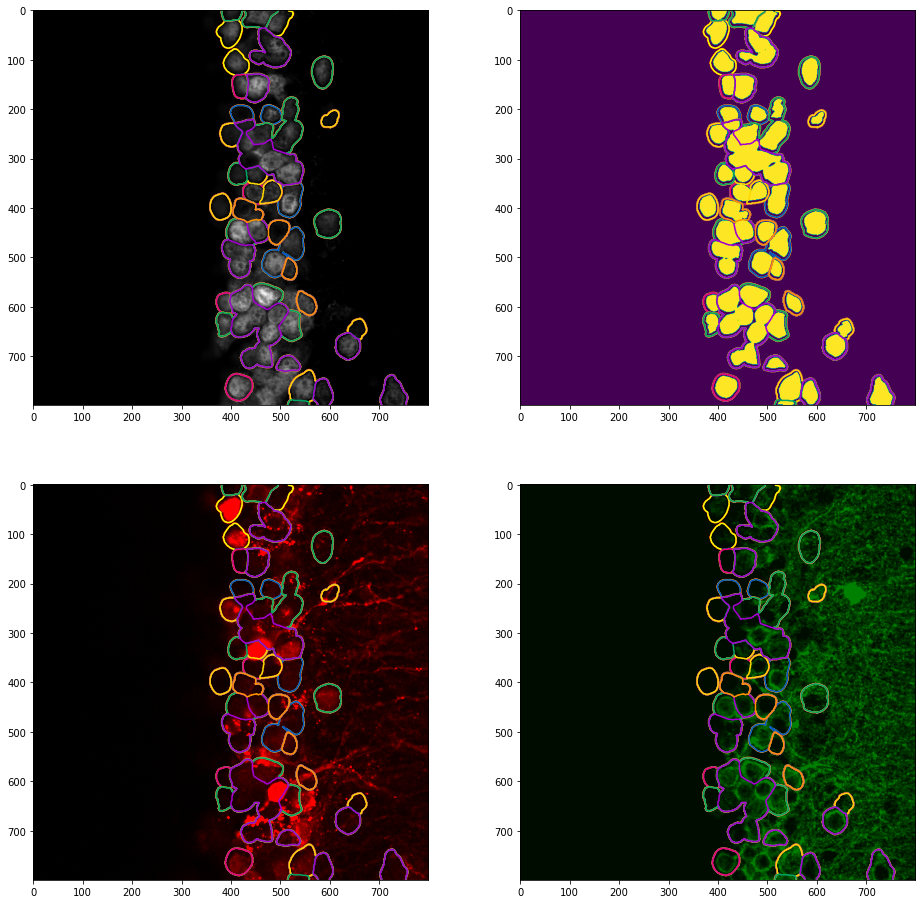

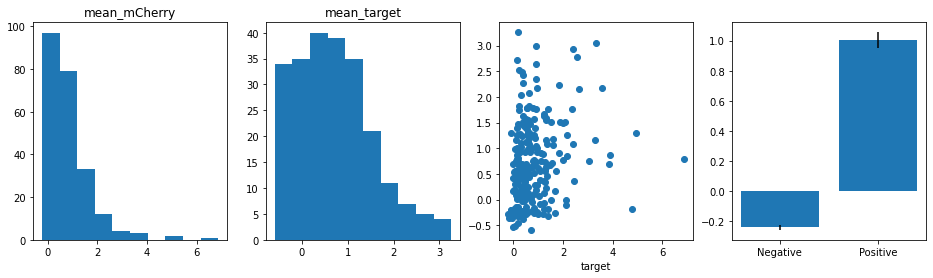

In [53]:
from matplotlib.projections.polar import Axes
fov = multi_image_results[0]
zi = 10
sp_size =16
fig, axs = plt.subplots(2,2,figsize=(sp_size,sp_size))
axs =axs.flatten()
axs[0].imshow(fov['image_znorm'][2,zi,:,:],cmap='gray')
axs[0].contour(fov['exp_masks'][zi,:,:],cmap='prism')


axs[1].imshow(fov['masks'][zi,:,:]>0)
axs[1].contour(fov['exp_masks'][zi,:,:],cmap='prism')

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
axs[2].imshow(fov['image_znorm'][1,zi,:,:],cmap=cmap, vmax=4)
axs[2].contour(fov['exp_masks'][zi,:,:],cmap='prism')


cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","green"])
axs[3].imshow(fov['image_znorm'][0,zi,:,:],cmap=cmap,vmin=-1, vmax=3)
axs[3].contour(fov['exp_masks'][zi,:,:],cmap='prism')


sp_size =4
n=4
cell_df = fov['cell_df']
fig, ax = plt.subplots(1,n,figsize=(n*sp_size,sp_size))
ax=ax.flatten()
_=ax[0].hist(cell_df['mean_mCherry'])
ax[0].title.set_text('mean_mCherry')
_=ax[1].hist(cell_df['mean_target'])
ax[1].title.set_text('mean_target')
ax[2].scatter(cell_df['mean_mCherry'],cell_df['mean_target'])
ax[2].set_xlabel('mCherry')
ax[2].set_xlabel('target')


vals=[cell_df['mean_target'][cell_df['mean_target']<0],
      cell_df['mean_target'][cell_df['mean_target']>0]]
means = [np.mean(v) for v in vals]
errors = [np.std(v)/np.sqrt(v.size) for v in vals]


ax[3].bar([0,1],means,yerr=errors)
ax[3].set_xticks([0,1])
ax[3].set_xticklabels(['Negative','Positive'])
# ax[3].set_xticks()
# ax[3].title.set_text('mean_NeuN')

plt.show()

In [46]:
fov['results'].keys()

dict_keys(['OR', 'num_RnG', 'num_nRnG', 'num_RG', 'num_nRG'])

In [10]:
chan_dim = 2
cell_chan = 2
z_dim = 3

# ch_names = ['target','mCherry','NeuN']


image_znorm, image_r,chan_dim,z_dim = norm_channels(image,chan_dim,z_dim,)

diameter = 30
exp_dist = 5
# masks, exp_masks = mask_image_cellpose(image_r,cell_chan,diameter,exp_dist)


cell_df = quant_cells(image_znorm, exp_masks,chan_dim)

results = calc_odd(cell_df)
print(results)



{'OR': 0.4707641196013289, 'num_RnG': 70, 'num_nRnG': 109, 'num_RG': 13, 'num_nRG': 43}
